(greenhouse:solution)=
# Greenhouse model

**Task 1**: Plug Eq. (7) into Eq. (6) and solve for the radiative equilibrium suface temperature $T_e$ 

In [1]:
# Solve for the radiative equilibrium temperature

sigma = 5.67e-8 # W m^-2 K^-4 
Q = 342         # Incoming shortwave radiation W m^-2
albedo = 0.3    # Albedo

Te = (((1-0.3)*342)/5.67e-8)**(1/4)

print('Radiative equilibrium temperature: {:.2f}'.format(Te))

Radiative equilibrium temperature: 254.91


**Task 2**: Where in the atmosphere do we find $T_e$?

In [2]:
from IPython.display import display, Markdown, Latex, Math
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
## The NOAA ESRL server is shutdown! January 2019
ncep = xr.open_dataset('./files/air.mon.ltm.1981-2010.nc',use_cftime=True)

ncep

<xarray.Dataset>
Dimensions:             (level: 17, lat: 73, lon: 144, time: 12, nbnds: 2)
Coordinates:
  * level               (level) float32 1e+03 925.0 850.0 ... 30.0 20.0 10.0
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time                (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:0...
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) object ...
    air                 (time, level, lat, lon) float32 ...
    valid_yr_count      (time, level, lat, lon) float32 ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    title:                          monthly ltm air from the NCEP Reanalysis
    dataset_title:                  NCEP-NCAR Reanalysis 1
    References:                     http://www.psl.noaa.gov/data/gridded/data...

In [4]:
# calculate the area-weighted temperature over its domain. This dataset has a regular latitude/ longitude grid, 
# thus the grid cell area decreases towards the pole. For this grid we can use the cosine of the latitude as proxy 
# for the grid cell area.
weights = np.cos(np.deg2rad(ncep.lat))

# Use the xarray function to weight the air temperature array
air_weighted = ncep.air.weighted(weights)

# Take the mean over lat/lon/time to get a mean vertical profile
weighted_mean = air_weighted.mean(("lat","lon", "time"))

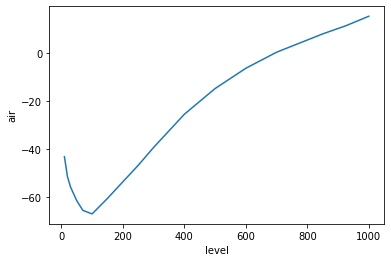

In [5]:
#  a "quick and dirty" visualization of the data
weighted_mean.plot()

In [6]:
# Import the metpy library
from metpy.plots import SkewT

Text(0.5, 1.0, 'Global, annual mean sounding from NCEP Reanalysis')

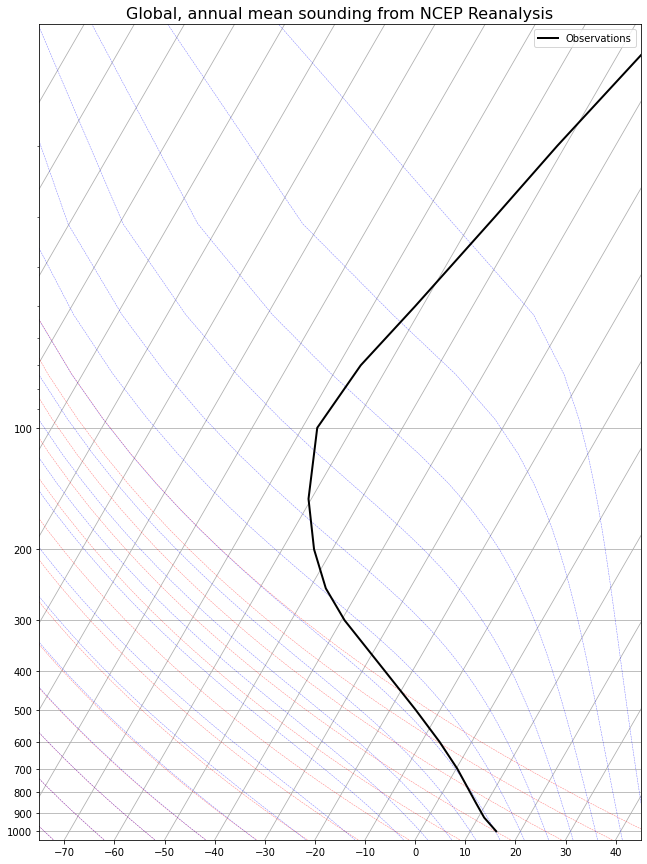

In [7]:
fig = plt.figure(figsize=(15, 15))

# Create the skew-plot with the metpy module (see manual for details)
skew = SkewT(fig, rotation=30)
skew.plot(weighted_mean.level, weighted_mean, color='black', linestyle='-', linewidth=2, label='Observations')

# Scale the x and y axis
skew.ax.set_ylim(1050, 10)
skew.ax.set_xlim(-75, 45)

# Add the adiabats to the plot
skew.plot_dry_adiabats(linewidth=0.5)
skew.plot_moist_adiabats(linewidth=0.5)

# Adde axis labels and legend
skew.ax.legend()
skew.ax.set_title('Global, annual mean sounding from NCEP Reanalysis', 
             fontsize = 16)

**Task 3**: What is the surface temperature with the single layer model? 

In [8]:
# Solve for the atmospheric surface temperature

# Calc surface temperature
Ts = 2**(1/4) * Te
print('Surface temperature: {:.2f}'.format(Ts))

Surface temperature: 303.14


Why does the model overestimate the surface temperature?

**Task 5**: Write a Python function for $OLR = U_2 = (1-\epsilon)^2 \sigma T_s^4 + \epsilon(1-\epsilon)\sigma T_0^4 + \epsilon \sigma T_1^4$

In [9]:
# The function calculates the OLR of the two-layer model
def two_layer_model(Ts, T0, T1, epsilon):
    return ((1-epsilon)**2)*sigma*Ts**4 + epsilon*(1-epsilon)*sigma*T0**4 + epsilon*sigma*T1**4

**Task 6**: We will tune our model so that it reproduces the observed global mean OLR given observed global mean temperatures. Determine the temperatures for the two-layer model from the following sounding

![alt text](pics/vertical_profile.png "Sounding")

**Task 8**: Find graphically the best fit value of $\epsilon$


The optimized transmissivity is: 0.59


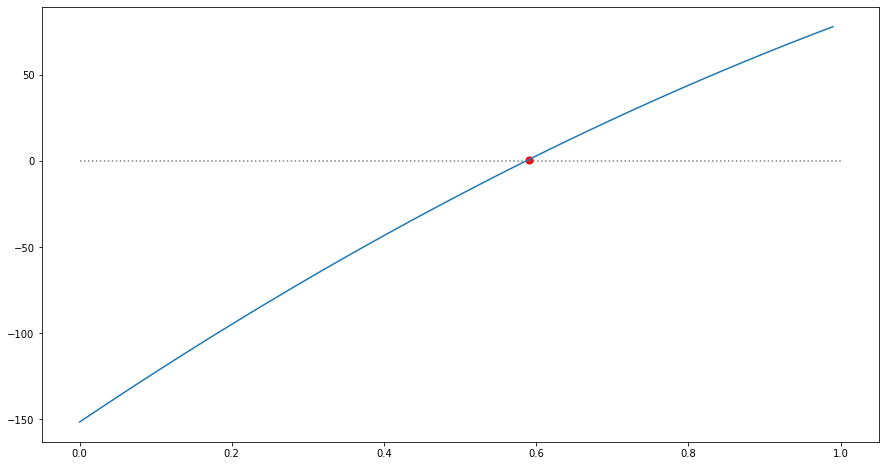

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Assignments
OLR = []        # initialize array
epsilons = []   # initialize array
OLR_obs = 238.5 # observed outgoing long-wave radiation

def find_nearest(array, value):
    """ 
    Auxiliary function to find index of closest value in an array 
    array :: input array
    value :: the value to find in the array
    """
    # This searches the minimum between the values and all values in an array
    # Basically, we enumerate over the array. The enumerator iterates over the array and returns a 
    # tuple (index, value) for each element. We take the value (x[1]) from this tuple and substract the value
    # we are searching for. The element which has the smallest difference is what we are looking for. We finally
    # return the index of this value.
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

# Optimize epsilon
# We define a range from 0 to 1 with a 0.01 step and calculate the OLR for each of these epsilon values
for eps in np.arange(0, 1, 0.01):
    OLR.append(OLR_obs - two_layer_model(288, 275, 230, eps))
    # Store the results in the epsilon-array
    epsilons.append(eps)

# Now, find the closest value to the observed OLR using the previously defined function
idx = find_nearest(OLR, 0)

# Save the optimized epsilon in the epsilons-array
epsilon = epsilons[idx]

# Plot the results
print('The optimized transmissivity is: {:.2f}'.format(epsilons[idx]))
plt.figure(figsize=(15,8))
plt.plot(epsilons,OLR);
plt.scatter(epsilons[idx], OLR[idx], s=50,  color='r')
plt.hlines(0,0,1,linestyles='dotted',color='gray');
    

In [11]:
# Validate the result
print('The modelled OLR is {:.2f}, while the observed value is 238.5'.format(two_layer_model(288, 275, 230, epsilon)))

The modelled OLR is 237.63, while the observed value is 238.5


**Task 9**: Write a Python function to calculate each term in the OLR. Plug-in the observed temperatures and the tuned value for epsilon.

In [12]:
def two_layer_terms(Ts, T0, T1, epsilon):
    """
    This is the same as the two-layer model but instead of returning the OLR this function return the 
    individual terms of the two-layer equation
    """
    return ( ((1-epsilon)**2)*sigma*Ts**4, epsilon*(1-epsilon)*sigma*T0**4, epsilon*sigma*T1**4)

In [13]:
# Calculates the individual terms
term1, term2, term3 = two_layer_terms(288, 275, 230, epsilon)

display(Markdown(r"""> **Term 1:** ${:.2f} ~ Wm^2$ <br> **Term 2:** ${:.2f} ~ Wm^2$ <br> **Term 3:** ${:.2f} ~ Wm^2$""".format(term1, term2, term3)))
display(Markdown(r"""> **Total** (sum of all terms): ${:.2f} ~ Wm^2$""".format(term1+term2+term3)))

> **Term 1:** $65.57 ~ Wm^2$ <br> **Term 2:** $78.44 ~ Wm^2$ <br> **Term 3:** $93.62 ~ Wm^2$

> **Total** (sum of all terms): $237.63 ~ Wm^2$

**Task 10**: Changing the level of emission by adding absorbers, e.g. by 10 %. 
Suppose further that this increase happens abruptly so that there is no time for the temperatures to respond to this change. We hold the temperatures fixed in the column and ask how the radiative fluxes change.

Which terms in the OLR go up and which go down?

In [14]:
# Calculates the individual terms
term1, term2, term3 = two_layer_terms(288, 275, 230, epsilon+0.1)

display(Markdown(r"""> **Term 1:** ${:.2f} ~ Wm^2$ <br> **Term 2:** ${:.2f} ~ Wm^2$ <br> **Term 3:** ${:.2f} ~ Wm^2$""".format(term1, term2, term3)))
display(Markdown(r"""> **Total** (sum of all terms): ${:.2f} ~ Wm^2$""".format(term1+term2+term3)))



> **Term 1:** $37.49 ~ Wm^2$ <br> **Term 2:** $69.36 ~ Wm^2$ <br> **Term 3:** $109.48 ~ Wm^2$

> **Total** (sum of all terms): $216.33 ~ Wm^2$

**Task 11**: Calculate the radiative forcing for the previous simulation

In [15]:
# First calculate the unperturbed terms
term1, term2, term3 = two_layer_terms(288, 275, 230, epsilon)
# Now, add the perturbation to the epsilon values
term1p, term2p, term3p = two_layer_terms(288, 275, 230, epsilon+0.1)

# Print the results
display(Markdown(r"""> **RS**: ${:.2f} ~ Wm^2$ <br>
                       **R0**: ${:.2f} ~ Wm^2$ <br>
                       **R1**: ${:.2f} ~ Wm^2$
                    """.format(-(term1p-term1),
                               -(term2p-term2),
                               -(term3p-term3))))

display(Markdown(r"""> **Radiative forcing**: ${:.2f} ~ Wm^2$""".format(-(term1p-term1)-(term2p-term2)-(term3p-term3))))

> **RS**: $28.09 ~ Wm^2$ <br>
                       **R0**: $9.08 ~ Wm^2$ <br>
                       **R1**: $-15.87 ~ Wm^2$
                    

> **Radiative forcing**: $21.30 ~ Wm^2$

**Task 12**: What is the greenhouse effect for an isothermal atmosphere?

In [16]:
# First calculate the unperturbed terms
term1, term2, term3 = two_layer_terms(288, 288, 288, epsilon)
# Now, add the perturbation to the epsilon values
term1p, term2p, term3p = two_layer_terms(288, 288, 288, epsilon+0.1)

# Print the results
display(Markdown(r"""> **RS**: ${:.2f} ~ Wm^2$ <br>
                       **R0**: ${:.2f} ~ Wm^2$ <br>
                       **R1**: ${:.2f} ~ Wm^2$
                    """.format(-(term1p-term1),
                               -(term2p-term2),
                               -(term3p-term3))))

display(Markdown(r"""> **Radiative forcing**: ${:.2f} ~ Wm^2$""".format(-(term1p-term1)-(term2p-term2)-(term3p-term3))))

> **RS**: $28.09 ~ Wm^2$ <br>
                       **R0**: $10.92 ~ Wm^2$ <br>
                       **R1**: $-39.01 ~ Wm^2$
                    

> **Radiative forcing**: $-0.00 ~ Wm^2$

**Task 13**: For a more realistic example of radiative forcing due to an increase in greenhouse absorbers, we use our observed temperatures and the tuned value for epsilon. Assume an increase of epsilon by 2 %.

In [17]:
# Perturb the epsilon values by 2 %
depsilon = epsilon * 0.02
print('The epsilon disturbance: {:.3f} \n'.format(depsilon))

term1, term2, term3 = two_layer_terms(288, 275, 230, epsilon)
term1p, term2p, term3p = two_layer_terms(288, 275, 230, epsilon+depsilon)

# Print the results
display(Markdown(r"""> **RS**: ${:.2f} ~ Wm^2$ <br>
                       **R0**: ${:.2f} ~ Wm^2$ <br>
                       **R1**: ${:.2f} ~ Wm^2$
                    """.format(-(term1p-term1),
                               -(term2p-term2),
                               -(term3p-term3))))

display(Markdown(r"""> **Radiative forcing**: ${:.2f} ~ Wm^2$""".format(-(term1p-term1)-(term2p-term2)-(term3p-term3))))

The epsilon disturbance: 0.012 



> **RS**: $3.72 ~ Wm^2$ <br>
                       **R0**: $0.73 ~ Wm^2$ <br>
                       **R1**: $-1.87 ~ Wm^2$
                    

> **Radiative forcing**: $2.58 ~ Wm^2$